In [1]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MovieLensRecommendation") \
    .config("spark.driver.memory", "50g") \
    .config("spark.executor.memory", "50g") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/21 09:52:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/21 09:52:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
ratings = spark.read.csv("ml-32m/ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("ml-32m/movies.csv", header=True, inferSchema=True)


In [4]:
ratings.show(10)
movies.show(10)


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
|     1|     34|   2.0|943228491|
|     1|     36|   1.0|944249008|
|     1|     80|   5.0|944248943|
|     1|    110|   3.0|943231119|
|     1|    111|   5.0|944249008|
+------+-------+------+---------+
only showing top 10 rows
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)| 

In [5]:
from pyspark.sql.functions import col, count, explode, split, isnan, when

# 1️⃣ Ratings distribution
print("🎯 Rating Value Distribution:")
ratings.groupBy("rating").count().orderBy("rating").show()

# 2️⃣ Movie Genre Distribution
# Explode the genres into separate rows for counting
genre_counts = movies.withColumn("genre", explode(split(col("genres"), "\\|"))) \
                     .groupBy("genre").count().orderBy(col("count").desc())

print("🎬 Movie Genre Distribution:")
genre_counts.show(truncate=False)

# 3️⃣ Count nulls
def count_nulls(df, name):
    print(f"⚠️ NULL Counts in {name}:")
    df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

count_nulls(ratings, "ratings")
count_nulls(movies, "movies")

# 4️⃣ Count duplicates
ratings_dup = ratings.count() - ratings.dropDuplicates().count()
movies_dup = movies.count() - movies.dropDuplicates().count()

print(f"🧹 Duplicate rows in ratings: {ratings_dup}")
print(f"🧹 Duplicate rows in movies: {movies_dup}")


🎯 Rating Value Distribution:


+------+-------+
|rating|  count|
+------+-------+
|   0.5| 525132|
|   1.0| 946675|
|   1.5| 531063|
|   2.0|2028622|
|   2.5|1685386|
|   3.0|6054990|
|   3.5|4290105|
|   4.0|8367654|
|   4.5|2974000|
|   5.0|4596577|
+------+-------+

🎬 Movie Genre Distribution:
+------------------+-----+
|genre             |count|
+------------------+-----+
|Drama             |34175|
|Comedy            |23123|
|Thriller          |11823|
|Romance           |10369|
|Action            |9668 |
|Documentary       |9363 |
|Horror            |8654 |
|(no genres listed)|7080 |
|Crime             |6976 |
|Adventure         |5402 |
|Sci-Fi            |4907 |
|Animation         |4617 |
|Children          |4520 |
|Mystery           |4013 |
|Fantasy           |3851 |
|War               |2325 |
|Western           |1696 |
|Musical           |1059 |
|Film-Noir         |353  |
|IMAX              |195  |
+------------------+-----+
only showing top 20 rows
⚠️ NULL Counts in ratings:


25/07/21 09:52:55 ERROR Executor: Exception in task 0.0 in stage 15.0 (TID 101) 
org.apache.spark.SparkNumberFormatException: [CAST_INVALID_INPUT] The value 'Toy Story (1995)' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"isnan" was called from
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)

	at org.apache.spark.sql.errors.QueryExecutionErrors$.invalidInputInCastToNumberError(QueryExecutionErrors.scala:145)
	at org.apache.spark.sql.errors.QueryExecutionErrors.invalidInputInCastToNumberError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregate_count_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doConsume

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

⚠️ NULL Counts in movies:


NumberFormatException: [CAST_INVALID_INPUT] The value 'Bawaal (2023)' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"isnan" was called from
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)


In [6]:
from pyspark.sql.functions import col, count, explode, split, isnan, when
from pyspark.sql.types import NumericType

# 1️⃣ Ratings distribution
print("🎯 Rating Value Distribution:")
ratings.groupBy("rating").count().orderBy("rating").show()

# 2️⃣ Movie Genre Distribution
genre_counts = movies.withColumn("genre", explode(split(col("genres"), "\\|"))) \
                     .groupBy("genre").count().orderBy(col("count").desc())

print("🎬 Movie Genre Distribution:")
genre_counts.show(truncate=False)

# 3️⃣ Count nulls safely
def count_nulls(df, name):
    print(f"⚠️ NULL Counts in {name}:")
    counts = []
    for c in df.columns:
        if isinstance(df.schema[c].dataType, NumericType):
            counts.append(count(when(col(c).isNull() | isnan(c), c)).alias(c))
        else:
            counts.append(count(when(col(c).isNull(), c)).alias(c))
    df.select(counts).show()

count_nulls(ratings, "ratings")
count_nulls(movies, "movies")

# 4️⃣ Count duplicates
ratings_dup = ratings.count() - ratings.dropDuplicates().count()
movies_dup = movies.count() - movies.dropDuplicates().count()

print(f"🧹 Duplicate rows in ratings: {ratings_dup}")
print(f"🧹 Duplicate rows in movies: {movies_dup}")


🎯 Rating Value Distribution:


+------+-------+
|rating|  count|
+------+-------+
|   0.5| 525132|
|   1.0| 946675|
|   1.5| 531063|
|   2.0|2028622|
|   2.5|1685386|
|   3.0|6054990|
|   3.5|4290105|
|   4.0|8367654|
|   4.5|2974000|
|   5.0|4596577|
+------+-------+

🎬 Movie Genre Distribution:
+------------------+-----+
|genre             |count|
+------------------+-----+
|Drama             |34175|
|Comedy            |23123|
|Thriller          |11823|
|Romance           |10369|
|Action            |9668 |
|Documentary       |9363 |
|Horror            |8654 |
|(no genres listed)|7080 |
|Crime             |6976 |
|Adventure         |5402 |
|Sci-Fi            |4907 |
|Animation         |4617 |
|Children          |4520 |
|Mystery           |4013 |
|Fantasy           |3851 |
|War               |2325 |
|Western           |1696 |
|Musical           |1059 |
|Film-Noir         |353  |
|IMAX              |195  |
+------------------+-----+
only showing top 20 rows
⚠️ NULL Counts in ratings:


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

⚠️ NULL Counts in movies:
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



🧹 Duplicate rows in ratings: 0
🧹 Duplicate rows in movies: 0


/tmp/ipykernel_3836/780555524.py:9: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratings_dist_pdf, x="rating", y="count", palette="magma")
/tmp/ipykernel_3836/780555524.py:13: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


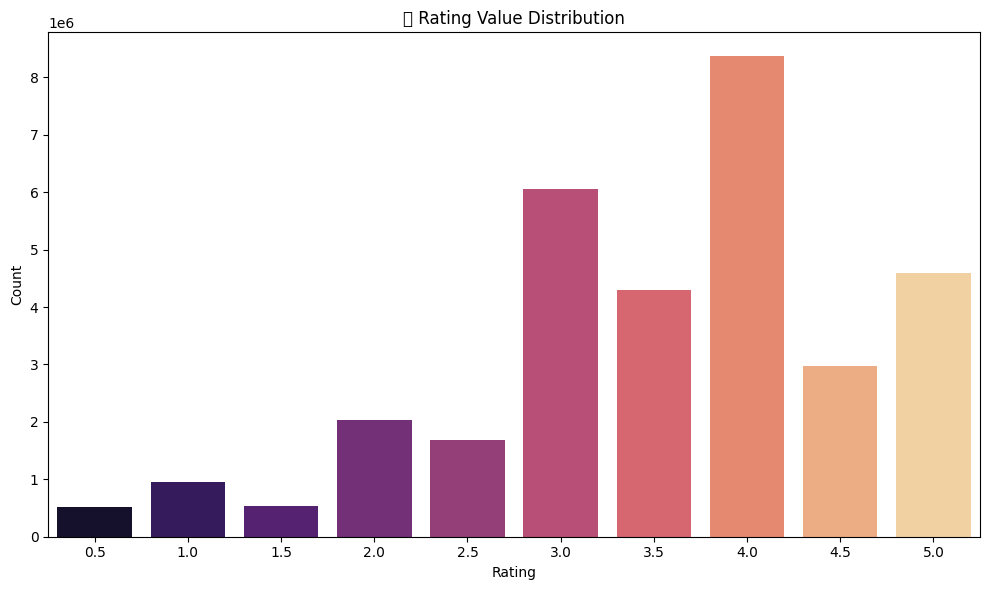

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Collect from Spark to Pandas
ratings_dist_pdf = ratings.groupBy("rating").count().orderBy("rating").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=ratings_dist_pdf, x="rating", y="count", palette="magma")
plt.title("🎯 Rating Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des données depuis Spark
ratings_pdf = ratings.select("rating").toPandas()

# Affichage avec une courbe lissée (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ratings_pdf, x="rating", fill=True, color="purple", linewidth=2)
plt.title("🎯 Distribution Continue des Ratings")
plt.xlabel("Note")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

/tmp/ipykernel_3836/3941752838.py:19: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


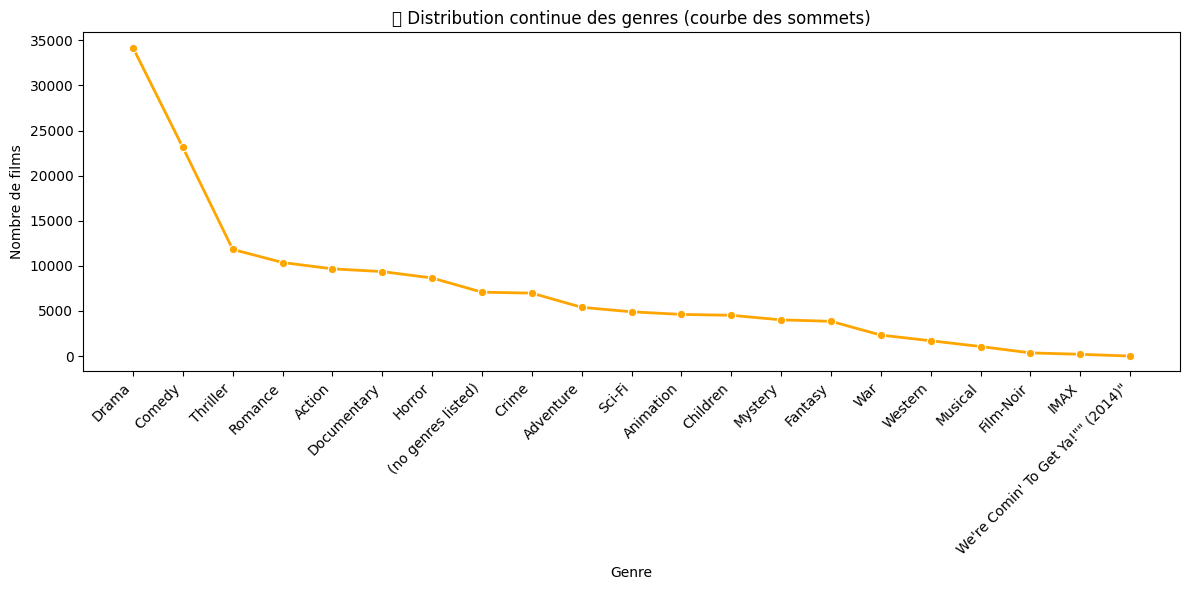

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Données de genre déjà calculées avec Spark
# genre_counts = movies.withColumn("genre", explode(split(col("genres"), "\\|")))...
genre_counts_pdf = genre_counts.toPandas().sort_values("count", ascending=False)

plt.figure(figsize=(12, 6))

# Courbe lissée passant par les sommets (sans scatter)
sns.lineplot(data=genre_counts_pdf, x=genre_counts_pdf.index, y="count", marker="o", linewidth=2, color="orange")

# Afficher les labels de genre sur l’axe des x
plt.xticks(ticks=genre_counts_pdf.index, labels=genre_counts_pdf["genre"], rotation=45, ha="right")

plt.title("🎬 Distribution continue des genres (courbe des sommets)")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3836/506868077.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


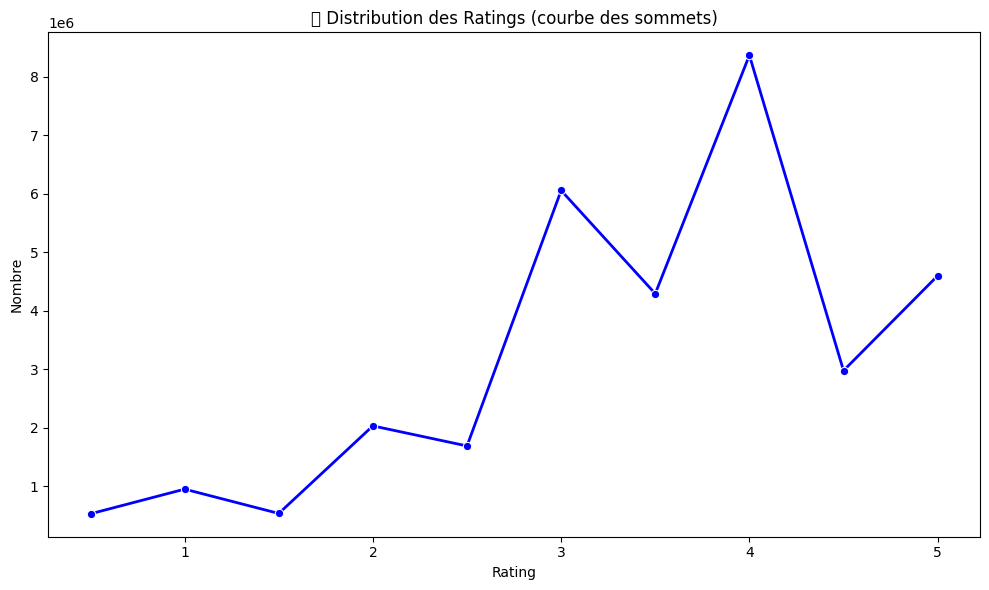

In [10]:
ratings_dist_pdf = ratings.groupBy("rating").count().orderBy("rating").toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=ratings_dist_pdf, x="rating", y="count", marker="o", color="blue", linewidth=2)

plt.title("🎯 Distribution des Ratings (courbe des sommets)")
plt.xlabel("Rating")
plt.ylabel("Nombre")
plt.tight_layout()
plt.show()


In [11]:
# Convert to Pandas for plotting
rating_dist_pdf = ratings.groupBy("rating").count().orderBy("rating").toPandas()
genre_counts_pdf = genre_counts.toPandas()

# Count of ratings per movie
rating_count_pdf = ratings.groupBy("movieId").count().withColumnRenamed("count", "num_ratings").toPandas()


/tmp/ipykernel_3836/2543596074.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_dist_pdf, x="rating", y="count", palette="coolwarm")
/tmp/ipykernel_3836/2543596074.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


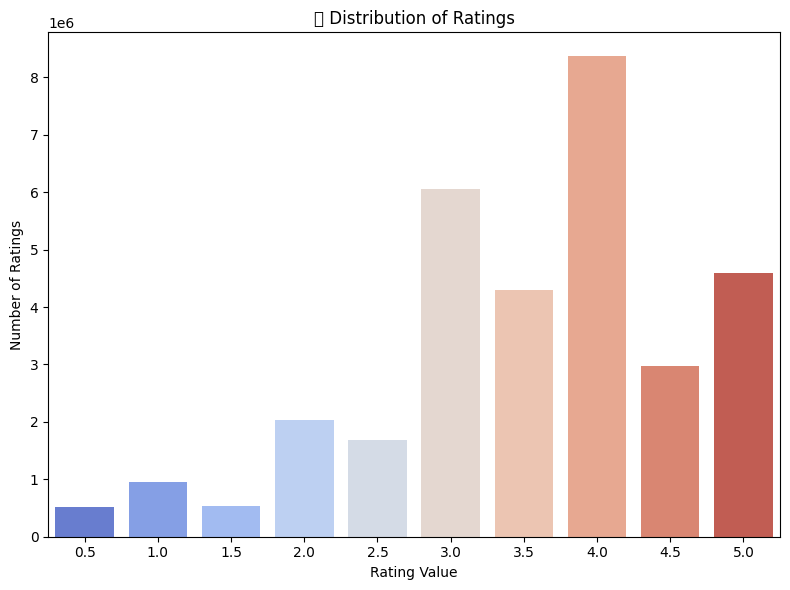

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(data=rating_dist_pdf, x="rating", y="count", palette="coolwarm")
plt.title("🎯 Distribution of Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3836/354709830.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_counts_pdf.sort_values("count", ascending=False),
/tmp/ipykernel_3836/354709830.py:7: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


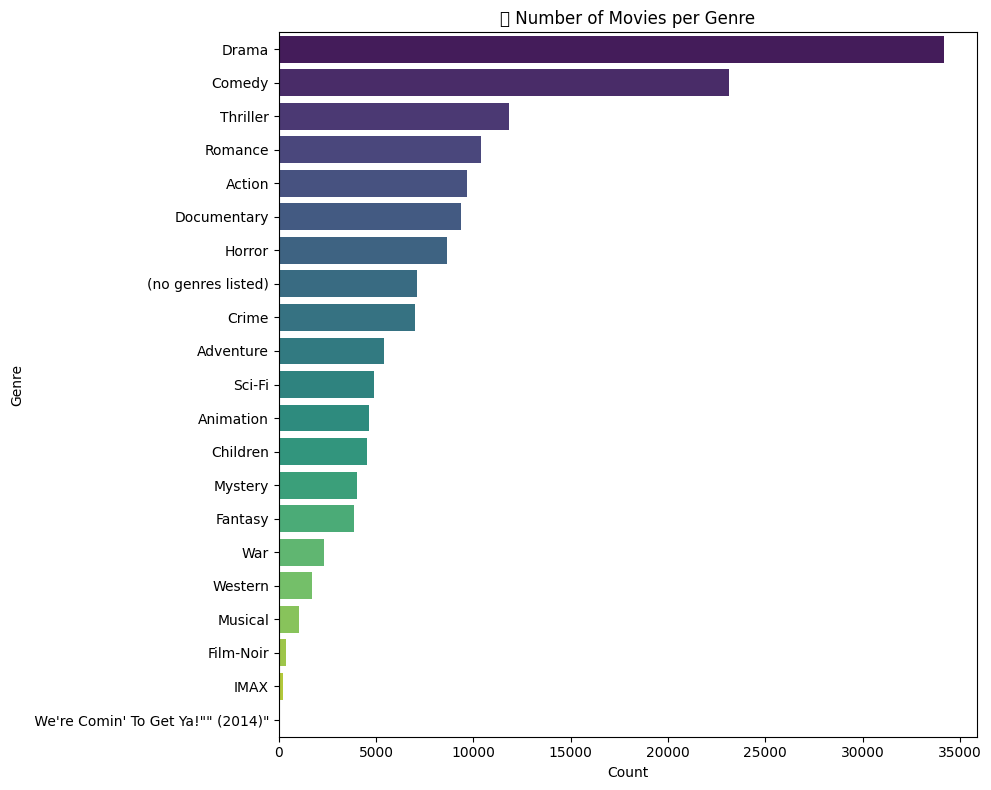

In [13]:
plt.figure(figsize=(10, 8))
sns.barplot(data=genre_counts_pdf.sort_values("count", ascending=False), 
            y="genre", x="count", palette="viridis")
plt.title("🎬 Number of Movies per Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


In [14]:
for genre in genre_counts_pdf["genre"].unique():
    print(genre)


Drama
Comedy
Thriller
Romance
Action
Documentary
Horror
(no genres listed)
Crime
Adventure
Sci-Fi
Animation
Children
Mystery
Fantasy
War
Western
Musical
Film-Noir
IMAX
 We're Comin' To Get Ya!"" (2014)"


/tmp/ipykernel_3836/1868061214.py:7: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/python/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


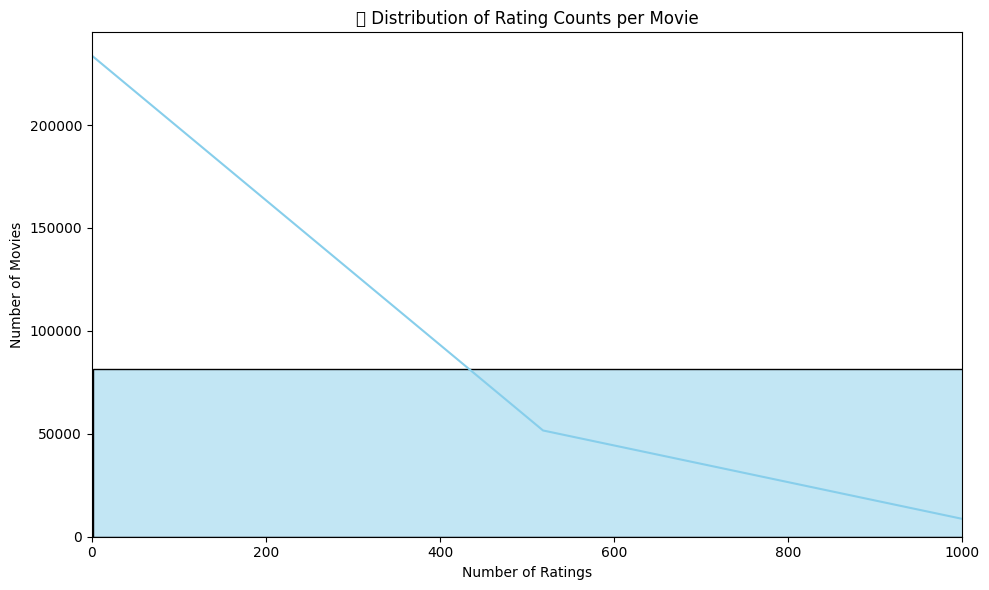

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(rating_count_pdf["num_ratings"], bins=50, kde=True, color="skyblue")
plt.title("🎥 Distribution of Rating Counts per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.xlim(0, 1000)  # zoom in on the most common values
plt.tight_layout()
plt.show()


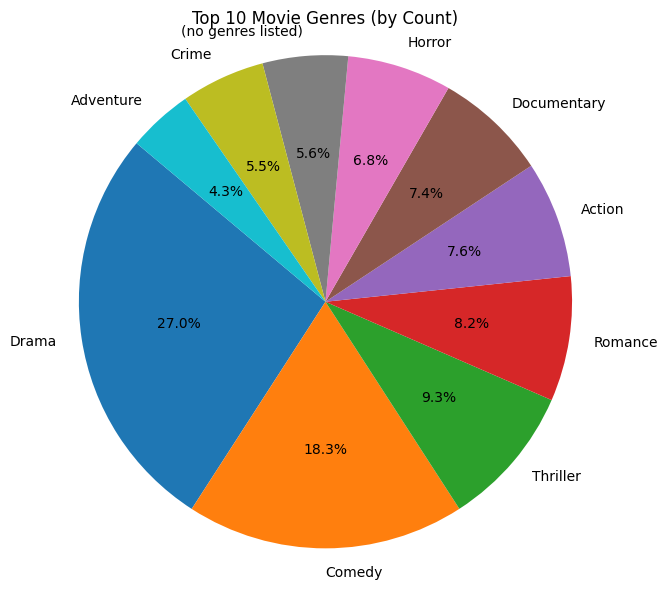

In [16]:
top_genres = genre_counts_pdf.sort_values("count", ascending=False).head(10)

plt.figure(figsize=(7, 7))
plt.pie(top_genres["count"], labels=top_genres["genre"], autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Movie Genres (by Count)")
plt.axis('equal')
plt.show()


In [17]:
print("Table movies (extrait) :")
movies.show(10, truncate=False)  # Affiche 10 lignes sans tronquer les colonnes


Table movies (extrait) :
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                       

In [18]:
print("Table ratings (extrait) :")
ratings.show(10, truncate=False)  # Affiche 10 lignes sans tronquer les colonnes


Table ratings (extrait) :
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |17     |4.0   |944249077|
|1     |25     |1.0   |944250228|
|1     |29     |2.0   |943230976|
|1     |30     |5.0   |944249077|
|1     |32     |5.0   |943228858|
|1     |34     |2.0   |943228491|
|1     |36     |1.0   |944249008|
|1     |80     |5.0   |944248943|
|1     |110    |3.0   |943231119|
|1     |111    |5.0   |944249008|
+------+-------+------+---------+
only showing top 10 rows


In [19]:
from pyspark.sql.functions import avg

# 1️⃣ Calcul de la moyenne des notes par film
avg_ratings = ratings.groupBy("movieId").agg(avg("rating").alias("global_rating"))

# 2️⃣ Jointure avec la table movies pour ajouter la colonne global_rating
movies_with_rating = movies.join(avg_ratings, on="movieId", how="left")

# 3️⃣ Afficher le résultat
movies_with_rating.show(10, truncate=False)


+-------+-------------------------------------------------------------------+-------------------------------------------+------------------+
|movieId|title                                                              |genres                                     |global_rating     |
+-------+-------------------------------------------------------------------+-------------------------------------------+------------------+
|289053 |Waterlife (2009)                                                   |Documentary                                |3.0               |
|1      |Toy Story (1995)                                                   |Adventure|Animation|Children|Comedy|Fantasy|3.8974375697494095|
|3      |Grumpier Old Men (1995)                                            |Comedy|Romance                             |3.1394472361809047|
|6      |Heat (1995)                                                        |Action|Crime|Thriller                      |3.8682773821634453|
|5      |Fath

In [20]:
movies_with_rating.filter(col("movieId") == 318).show(truncate=False)


[Stage 99:==============================================>         (25 + 5) / 30]

+-------+--------------------------------+-----------+-----------------+
|movieId|title                           |genres     |global_rating    |
+-------+--------------------------------+-----------+-----------------+
|318    |Shawshank Redemption, The (1994)|Crime|Drama|4.404613860039444|
+-------+--------------------------------+-----------+-----------------+



In [21]:
from pyspark.sql.functions import col

ratings = ratings.dropna().dropDuplicates()
movies = movies.dropna().dropDuplicates()


In [22]:
from pyspark.sql.functions import avg, count

top_movies = ratings.groupBy("movieId") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("count_rating")) \
    .filter("count_rating >= 50") \
    .join(movies, "movieId") \
    .orderBy("avg_rating", ascending=False)

top_movies.show(10)


[Stage 109:==================================================>    (31 + 3) / 34]

+-------+------------------+------------+--------------------+------------------+
|movieId|        avg_rating|count_rating|               title|            genres|
+-------+------------------+------------+--------------------+------------------+
| 171011|4.4468302658486705|        1956|Planet Earth II (...|       Documentary|
| 159817| 4.444369063772049|        2948| Planet Earth (2006)|       Documentary|
| 170705| 4.426538598363572|        2811|Band of Brothers ...|  Action|Drama|War|
|    318| 4.404613860039444|      102929|Shawshank Redempt...|       Crime|Drama|
| 171495| 4.330081300813008|         615|              Cosmos|(no genres listed)|
|    858| 4.317030403371463|       66440|Godfather, The (1...|       Crime|Drama|
| 202439| 4.312253641816624|       11670|     Parasite (2019)|      Comedy|Drama|
| 179135| 4.300085984522786|        1163|Blue Planet II (2...|       Documentary|
| 198185| 4.298684210526316|        1140|   Twin Peaks (1989)|     Drama|Mystery|
| 220528|  4.286

In [23]:
from pyspark.sql.functions import explode, split

genre_df = movies.withColumn("genre", explode(split(col("genres"), "\\|")))
genre_counts = genre_df.groupBy("genre").count().orderBy("count", ascending=False)
genre_counts.show()


+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|34175|
|            Comedy|23123|
|          Thriller|11823|
|           Romance|10369|
|            Action| 9668|
|       Documentary| 9363|
|            Horror| 8654|
|(no genres listed)| 7080|
|             Crime| 6976|
|         Adventure| 5402|
|            Sci-Fi| 4907|
|         Animation| 4617|
|          Children| 4520|
|           Mystery| 4013|
|           Fantasy| 3851|
|               War| 2325|
|           Western| 1696|
|           Musical| 1059|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+
only showing top 20 rows


In [24]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import rand

# Séparer en train/test
(training, test) = ratings.randomSplit([0.8, 0.2])

als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=10,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE =", rmse)


[Stage 261:==========>                                            (6 + 27) / 33]

RMSE = 0.8016798457973603


In [25]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# Remplacer les "|" par des espaces dans la colonne "genres"
movie_genres = movies.withColumn("genres_text", regexp_replace(col("genres"), r"\|", " "))

# Tokenisation du texte des genres
tokenizer = Tokenizer(inputCol="genres_text", outputCol="words")
words_data = tokenizer.transform(movie_genres)


In [26]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=100)
featurized = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized)
tfidf_movies = idf_model.transform(featurized)

In [27]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

movie_genres = movies.withColumn("genres_text", col("genres").replace("|", " "))

tokenizer = Tokenizer(inputCol="genres_text", outputCol="words")
words_data = tokenizer.transform(movie_genres)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=100)
featurized = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized)
tfidf_movies = idf_model.transform(featurized)


TypeError: 'Column' object is not callable

In [28]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

movie_genres = movies.withColumn("genres_text", col("genres").replace("|", " "))

tokenizer = Tokenizer(inputCol="genres_text", outputCol="words")
words_data = tokenizer.transform(movie_genres)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=100)
featurized = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized)
tfidf_movies = idf_model.transform(featurized)


TypeError: 'Column' object is not callable

In [29]:
user_ids = [1, 42, 100, 120, 150]

for user_id in user_ids:
    print(f"Recommandations pour l'utilisateur {user_id} :")
    user_recs = model.recommendForAllUsers(5).filter(col("userId") == user_id)
    user_recs.show(truncate=False)


Recommandations pour l'utilisateur 1 :


+------+-------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                        |
+------+-------------------------------------------------------------------------------------------------------+
|1     |[{289897, 5.244323}, {286911, 5.244323}, {194434, 5.2291203}, {193817, 5.1852345}, {259323, 5.1820183}]|
+------+-------------------------------------------------------------------------------------------------------+

Recommandations pour l'utilisateur 42 :


+------+------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                       |
+------+------------------------------------------------------------------------------------------------------+
|42    |[{177209, 5.872099}, {185291, 5.7076077}, {166812, 5.623586}, {196787, 5.366715}, {203882, 5.3385277}]|
+------+------------------------------------------------------------------------------------------------------+

Recommandations pour l'utilisateur 100 :


+------+-------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                        |
+------+-------------------------------------------------------------------------------------------------------+
|100   |[{177209, 5.697371}, {194434, 5.369706}, {231289, 5.2631197}, {231287, 5.2631197}, {219031, 5.2631197}]|
+------+-------------------------------------------------------------------------------------------------------+

Recommandations pour l'utilisateur 120 :


+------+------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                       |
+------+------------------------------------------------------------------------------------------------------+
|120   |[{194434, 6.674683}, {177209, 6.3253975}, {275847, 6.1745977}, {193817, 6.126486}, {231289, 6.113799}]|
+------+------------------------------------------------------------------------------------------------------+

Recommandations pour l'utilisateur 150 :


+------+-------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                        |
+------+-------------------------------------------------------------------------------------------------------+
|150   |[{151989, 6.1143785}, {193817, 6.1093035}, {194434, 5.9314384}, {289897, 5.857135}, {286911, 5.857135}]|
+------+-------------------------------------------------------------------------------------------------------+



In [30]:
item_factors = model.itemFactors
item_factors_pd = item_factors.toPandas()


In [31]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Convert features to matrix
X = np.vstack(item_factors_pd['features'].values)

# Fit KNN
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
knn.fit(X)

# Optional: Create item ID to index mapping
item_id_to_index = {row['id']: i for i, row in item_factors_pd.iterrows()}
index_to_item_id = {i: row['id'] for i, row in item_factors_pd.iterrows()}


In [32]:
def get_similar_items(item_id, top_k=5):
    idx = item_id_to_index[item_id]
    distances, indices = knn.kneighbors([X[idx]], n_neighbors=top_k+1)  # +1 to skip the item itself
    similar_items = [index_to_item_id[i] for i in indices[0][1:]]
    return similar_items


In [39]:
from pyspark.ml.recommendation import ALSModel
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# --- 1. Charger / avoir ton modèle ALS entraîné ---
# model = ALSModel.load("chemin/vers/ton/model")  # Exemple

# --- 2. Extraire les facteurs items (features) ---
item_factors = model.itemFactors  # Spark DataFrame avec colonnes ['id', 'features']

# Convertir en pandas pour sklearn
item_factors_pd = item_factors.toPandas()

# --- 3. Créer la matrice numpy des features ---
X = np.vstack(item_factors_pd['features'].values)

# --- 4. Créer mappings entre item_id et index ---
item_id_to_index = {row['id']: i for i, row in item_factors_pd.iterrows()}
index_to_item_id = {i: row['id'] for i, row in item_factors_pd.iterrows()}

# --- 5. Entraîner le modèle KNN ---
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
knn.fit(X)

# --- 6. Fonction pour récupérer les K plus proches voisins d’un item ---
def get_similar_items(item_id, top_k=5):
    idx = item_id_to_index[item_id]
    distances, indices = knn.kneighbors([X[idx]], n_neighbors=top_k + 1)  # +1 car on skip l’item lui-même
    similar_items = [index_to_item_id[i] for i in indices[0][1:]]
    return similar_items

# --- 7. Fonction pour combiner recommandations ALS + voisins KNN ---
def get_recommendations_with_neighbors(user_id, model, top_n=10, knn_k=3):
    user_df = spark.createDataFrame([(user_id,)], ["userId"])
    recs = model.recommendForUserSubset(user_df, top_n).collect()
    print(recs)
    print(type(recs[0]))
    print(recs[0].recommendations)
    print(type(recs[0].recommendations[0]))
    print(recs[0].recommendations[0].asDict())

    if len(recs) == 0:
        return []

    user_recs = []
    for rec in recs[0].recommendations:
        item_id = rec['movieId']  # Correction
     
        user_recs.append(item_id)
        neighbors = get_similar_items(item_id, top_k=knn_k)
        user_recs.extend(neighbors)

    user_recs = list(dict.fromkeys(user_recs))
    return user_recs

# --- Exemple d’utilisation ---
user_id_example = 123  # Remplace par un user_id réel
recommendations = get_recommendations_with_neighbors(user_id_example, model, top_n=10, knn_k=3)
print(f"Recommandations ALS + voisins KNN pour user {user_id_example} :\n", recommendations)


[Row(userId=123, recommendations=[Row(movieId=267220, rating=5.3373212814331055), Row(movieId=177209, rating=5.317698001861572), Row(movieId=270306, rating=5.221380233764648), Row(movieId=240070, rating=5.221380233764648), Row(movieId=240054, rating=5.221380233764648), Row(movieId=235787, rating=5.208349704742432), Row(movieId=190521, rating=5.151626110076904), Row(movieId=162436, rating=5.1291608810424805), Row(movieId=133994, rating=5.097340106964111), Row(movieId=173945, rating=5.076116561889648)])]
<class 'pyspark.sql.types.Row'>
[Row(movieId=267220, rating=5.3373212814331055), Row(movieId=177209, rating=5.317698001861572), Row(movieId=270306, rating=5.221380233764648), Row(movieId=240070, rating=5.221380233764648), Row(movieId=240054, rating=5.221380233764648), Row(movieId=235787, rating=5.208349704742432), Row(movieId=190521, rating=5.151626110076904), Row(movieId=162436, rating=5.1291608810424805), Row(movieId=133994, rating=5.097340106964111), Row(movieId=173945, rating=5.07611

In [40]:
from pyspark.ml.recommendation import ALSModel
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# --- 1. Charger / avoir ton modèle ALS entraîné ---
# model = ALSModel.load("chemin/vers/ton/model")  # Exemple

# --- 2. Extraire les facteurs items (features) ---
item_factors = model.itemFactors  # Spark DataFrame avec colonnes ['id', 'features']

# Convertir en pandas pour sklearn
item_factors_pd = item_factors.toPandas()

# --- 3. Créer la matrice numpy des features ---
X = np.vstack(item_factors_pd['features'].values)

# --- 4. Créer mappings entre item_id et index ---
item_id_to_index = {row['id']: i for i, row in item_factors_pd.iterrows()}
index_to_item_id = {i: row['id'] for i, row in item_factors_pd.iterrows()}

# --- 5. Entraîner le modèle KNN ---
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
knn.fit(X)

# --- 6. Fonction pour récupérer les K plus proches voisins d’un item ---
def get_similar_items(item_id, top_k=5):
    idx = item_id_to_index[item_id]
    distances, indices = knn.kneighbors([X[idx]], n_neighbors=top_k + 1)  # +1 pour skip l’item lui-même
    similar_items = [index_to_item_id[i] for i in indices[0][1:]]
    return similar_items

# --- 7. Fonction pour combiner recommandations ALS + voisins KNN ---
def get_recommendations_with_neighbors(user_id, model, top_n=10, knn_k=3):
    user_df = spark.createDataFrame([(user_id,)], ["userId"])
    recs = model.recommendForUserSubset(user_df, top_n).collect()

    if len(recs) == 0:
        return []

    user_recs = []
    for rec in recs[0].recommendations:
        item_id = rec['movieId']
        user_recs.append(item_id)
        neighbors = get_similar_items(item_id, top_k=knn_k)
        user_recs.extend(neighbors)

    # Remove duplicates while preserving order
    user_recs = list(dict.fromkeys(user_recs))
    return user_recs

# --- 8. Fonction d’évaluation précision@k ---
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    hits = sum(1 for item in recommended_at_k if item in relevant_items)
    return hits / k if k > 0 else 0

# --- Exemple d’utilisation et évaluation ---
user_id_example = 123  # Remplace par un user_id réel

# Exemple de vérité terrain (items réellement appréciés par cet utilisateur dans un test set)
user_relevant_items = {
    123: [270306, 177209, 240070, 162436, 133994]  # Remplace par tes vrais données test
}

recommendations = get_recommendations_with_neighbors(user_id_example, model, top_n=10, knn_k=3)
print(f"Recommandations ALS + voisins KNN pour user {user_id_example} :\n", recommendations)

precision = precision_at_k(recommendations, user_relevant_items.get(user_id_example, []), k=10)
print(f"Précision@10 pour user {user_id_example} : {precision:.2f}")


Recommandations ALS + voisins KNN pour user 123 :
 [267220, 231741, 213415, 180759, 177209, 84372, 1689, 1425, 270306, 240070, 220112, 240054, 235787, 261647, 285907, 133994, 190521, 155758, 232005, 200106, 162436, 204546, 204274, 82045, 173945, 181901, 181895, 168144]
Précision@10 pour user 123 : 0.30
